In [1]:
import numpy as np
from tqdm import tqdm
from ipynb.fs.full.Preprocessing import preprocess

# Importing Data

In [2]:
train_x, train_y, test_x, test_y = preprocess(100000)

In [3]:
def one_hot(array, num_classes):
    eye = np.eye(num_classes)
    return np.squeeze(eye[array.astype(np.int64)])
test_y=one_hot(array = test_y,num_classes=3)
train_y=one_hot(array = train_y,num_classes=3)

# The code of the Neural Network

In [4]:
class Layer:
    def __init__(self, activation_func, size, weights=None,local_fields = None,after_activations=None,bias = 0 ):
        self.activation_func = activation_func #softmax, relu
        self.size =size #number of neurons  
        self.weights = weights
        self.local_fields=local_fields
class Sequential_Model: 
    def __init__(self, input_size, learning_rate,batch_size=12,layer_list = list(),weight_matrix = None,loss_type = "cross_categorical_entropy"):
        self.indicator = 0
        self.input_size = input_size
        self.layer_list = layer_list #input node, hidden node or output node   
        self.learning_rate = learning_rate
        self.weight_matrix = weight_matrix
        #self.epoch=100
        self.batch_size = batch_size
        self.loss_type = loss_type
        self.local_field_list = list() 
        self.activation_list = list()
        self.error_list=list()
        self.val_error_list = list()
        self.best_weights = list()
        self.best_val_loss = np.inf

    def activation(self,induced_local_field,actv_func):
        if actv_func == "relu":
            return max(induced_local_field,0)
        elif actv_func == "sigmoid":# or actv_func == "softmax":
            return 1/(1+np.exp(-induced_local_field))
        elif actv_func == "linear":
            return induced_local_field
        elif actv_func == "softmax":
            return np.exp(induced_local_field)
        else:
            raise ValueError("The activation function was not recognized.")
    def add(self,layer):
        self.layer_list.append(layer)
    def compile(self):
        weight_matrices = list()
        for ind in range(len(self.layer_list)-1):# Initializing the weight matrices
            weight_matrices.append(np.matrix(
                np.random.normal(loc=0.0,
                scale=np.sqrt(2/self.layer_list[ind].size),
                size=(self.layer_list[ind+1].size,
                self.layer_list[ind].size+1)))) #+1 is for bias. so, the rightmost column is the bias weight column.
        
        self.weight_matrix=weight_matrices
    def predict(self,model_input):
        actv = np.vectorize(self.activation,otypes=[np.float32])
        estimation = np.transpose(np.matrix(model_input))#,shape=(np.size(model_input),1))
        r,c = np.shape(estimation)
        for ind,matrix in enumerate(self.weight_matrix):
            estimation=matrix*(np.concatenate((estimation,np.ones((1,c))),axis=0))
            estimation = actv(estimation,self.layer_list[ind+1].activation_func)
        if self.layer_list[-1].activation_func=="softmax":
            return estimation/sum(estimation)
    def feed_forward_train(self,model_input):
        self.local_field_list = list() #resetting local field list
        self.activation_list = list()
        actv = np.vectorize(self.activation,otypes=[np.float32])
        estimation = np.transpose(np.matrix(model_input))#,shape=(np.size(model_input),1))
        self.activation_list.append(estimation)
        self.local_field_list.append(estimation)
        for ind,matrix in enumerate(self.weight_matrix):
            estimation=matrix*(np.concatenate((estimation,np.ones((1,1))),axis=0))
            self.local_field_list.append(estimation)
            estimation = actv(estimation,self.layer_list[ind+1].activation_func)
            self.activation_list.append(estimation)
        
        if self.layer_list[-1].activation_func=="softmax":
            if not np.isnan(estimation.any()):
                return estimation/(sum(estimation)+1e-5)
            else:
                self.indicator = 1
                return estimation/(sum(estimation)+1e-5)
        

        return estimation
    def loss_calc(self,est,truth):
        
        if self.loss_type=="cross_categorical_entropy":
            return np.sum(np.array(truth * -np.log(est+1e-15)), axis=-1, keepdims=False)
        elif self.loss_type=="mean_squared_error":
            return (np.norm(est-truth)**2)/len(truth)
        else:
            raise ValueError("Loss type not recognized.")
    def gradient(self,input,activation_func):
        if activation_func == "relu":
            return 1*(input>=0)
        elif activation_func == "linear":
            return 1
        return 0
    def train(self,X,y,epoch,learning_rate,val_size):
        
        self.learning_rate= learning_rate
        r,c = np.shape(X)
        X,val_X = X[:(r-val_size)],X[(r-val_size):]
        y,val_y = y[:(r-val_size)],y[(r-val_size):]
        for epoc in range(epoch):
            #try:
            #    self.error_list.append(error/self.batch_size)
            #    self.val_error_list.append(val_error/(val_size))
            #except:
                #pass
            tqdm_obj = tqdm(range(len(X)//self.batch_size))
            for batc in tqdm_obj:
                indices = np.random.choice(np.shape(X)[0],self.batch_size,replace=False)
                mini_x,mini_y = X[indices,:], y[indices,:]
                error=0
                val_error = 0
                placeholder = list()
                for ind,entry in enumerate(mini_x):
                    model_out = self.feed_forward_train(entry)
                    error += self.loss_calc(model_out,mini_y[ind])
                    vec_loss = model_out-np.matrix(mini_y[ind]).transpose()
                    placeholder.append(self.backpropagate(error,vec_loss))
                    try:
                        self.error_list.append(error/self.batch_size)
                    except:
                        pass

                
                model_val = self.predict(val_X)
                    
                for i in range(val_size):
                    val_error += self.loss_calc(model_val[:,i],val_y[i])
                try:
                    self.val_error_list.append(val_error/(val_size))
                except:
                    pass
                if val_error<self.best_val_loss:
                    self.best_val_loss = val_error
                    self.best_weights = self.weight_matrix


                str_epoc=str(epoc)
                str_error = '{:.2f}'.format(float(error/self.batch_size))
                str_val_error = '{:.2f}'.format(float(val_error/(val_size)))

                tqdm_obj.set_description("| Epoch:"+str_epoc+" | Loss:" + str_error + " | Validation Loss:"+ str_val_error +" |")
                    
                for ind,items in enumerate(zip(*placeholder)):
                    self.weight_matrix[ind] = np.sum(items, axis=0)/self.batch_size
                placeholder = list()
        self.weight_matrix = self.best_weights
            
    def backpropagate(self,error,vec_loss):
        list_of_deltas = [vec_loss]
        for ind in reversed(range(len(self.layer_list)-1)):
            A = self.weight_matrix[ind][:,:-1].transpose()*list_of_deltas[-1]
            B = self.gradient(self.local_field_list[ind],self.layer_list[ind].activation_func)
            C = np.multiply(A,B)
            list_of_deltas.append(C)
        list_of_deltas.reverse()
        ret_wm = self.weight_matrix
        for ind in range(len(self.weight_matrix)):
            delta = np.matrix(list_of_deltas[ind+1])
            actv = np.matrix(self.activation_list[ind])
            update = self.learning_rate*(delta*actv.transpose())
            ret_wm[ind][:,:-1] -= update.astype('float32')
            param = np.asarray(self.learning_rate*delta)
            try:
                ret_wm[ind][:,-1] = ret_wm[ind][:,-1]-param #np.squeeze(np.asarray(param))
            except:
                ret_wm[ind][:,-1] = ret_wm[ind][:,-1]-np.squeeze(param)
        list_of_deltas = list()
        self.local_field_list = list()
        self.activation_list = list()
        return ret_wm   


In [5]:
bacth_size = 100
model = Sequential_Model(input_size=12,loss_type = "cross_categorical_entropy",learning_rate=0.001,batch_size=bacth_size)
model.add(Layer(activation_func="linear", size=12))
model.add(Layer(activation_func="relu",size=64))
model.add(Layer(activation_func="relu",size=32))
model.add(Layer(activation_func="softmax",size=3))
model.compile()

In [7]:
model.train(train_x,train_y,epoch=5,learning_rate=0.001,val_size=5000)

| Epoch:0 | Loss:0.08 | Validation Loss:0.12 |:  36%|███▋      | 271/746 [02:24<04:12,  1.88it/s]


KeyboardInterrupt: 

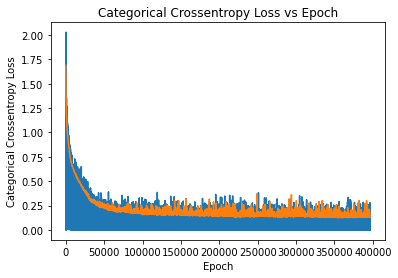

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title("Categorical Crossentropy Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Categorical Crossentropy Loss")
plt.plot(range(len(model.error_list)),model.error_list)
plt.plot(np.arange(len(model.val_error_list))*bacth_size,model.val_error_list)

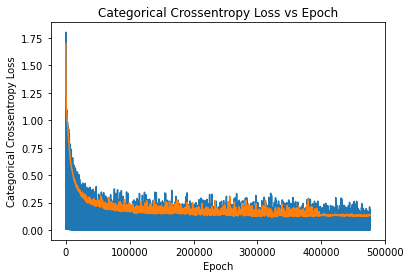

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title("Categorical Crossentropy Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Categorical Crossentropy Loss")
plt.plot(range(len(model.error_list)),model.error_list)
plt.plot(np.arange(len(model.val_error_list))*bacth_size,model.val_error_list)

In [7]:
truth = np.argmax(test_y,axis=1)
pred = np.argmax(model.predict(test_x),axis=0)
pred = np.array(pred).squeeze()
accuracy = sum(pred ==truth)/len(truth)
accuracy


0.9596

# Saving the model

In [10]:
"""
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)


save_object(model, 'nn_model.pkl')
"""

In [20]:
"""
with open('nn_model.pkl', 'rb') as pickle_file:
    model2 = pickle.load(pickle_file)
"""

# Performance Analysis

In [7]:
from line_profiler import LineProfiler
lp = LineProfiler()
lp.enable_by_count()
lp_wrapper = lp(Sequential_Model.feed_forward_train)
model.train(train_x,train_y,epoch=1,learning_rate=0.001,val_size=200)
lp.print_stats()

| Epoch:0 | Loss:0.17 | Validation Loss:0.12 |: 100%|██████████| 158/158 [01:15<00:00,  2.11it/s]

Timer unit: 1e-07 s

Total time: 29.4661 s
File: C:\Users\Onat\AppData\Local\Temp/ipykernel_2308/2659015140.py
Function: feed_forward_train at line 62

Line #      Hits         Time  Per Hit   % Time  Line Contents
    62                                               def feed_forward_train(self,model_input):
    63     79000    1443486.0     18.3      0.5          self.local_field_list = list() #resetting local field list
    64     79000     776143.0      9.8      0.3          self.activation_list = list()
    65     79000   11926417.0    151.0      4.0          actv = np.vectorize(self.activation,otypes=[np.float32])
    66     79000   23931824.0    302.9      8.1          estimation = np.transpose(np.matrix(model_input))#,shape=(np.size(model_input),1))
    67     79000     996944.0     12.6      0.3          self.activation_list.append(estimation)
    68     79000     652795.0      8.3      0.2          self.local_field_list.append(estimation)
    69    316000    3077859.0      9.7